<a href="https://colab.research.google.com/github/AviRahimov/AMFLU_Assignment1/blob/main/Advanced_Models_For_Language_Understanding_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-df/train.csv
/kaggle/input/test-no-target/test_no_target.csv


# 🔹 Assignment 1: Seq2Seq Model for Sentence Unshuffling
In this assignment, you'll implement a basic **Sequence-to-Sequence (Seq2Seq)** neural network using PyTorch.

### 🎯 **Your goal:**
Given a sentence whose words have been shuffled randomly, your model must reconstruct the original sentence.

**Example:**

| Input (shuffled) | Output (original) |
|-----------------|------------------|
| `mat the on sat cat The` | `The cat sat on the mat` |

## 🔹 Why this task?
This simple yet non-trivial task demonstrates how language models learn word-order and syntactic structures.
From a psycholinguistic viewpoint, sentence reconstruction taps into:

- **Working memory**: The model must hold multiple words and reorder them meaningfully.
- **Syntax and semantics**: Reordering depends on syntactic constraints and semantic coherence.

## 🔹 Quick Summary of PyTorch Workflow

The general workflow when working with on deep learning with PyTorch usually involves these steps:

1. **Prepare your data**:
    - Define your dataset by subclassing `torch.utils.data.Dataset`.
    - Use a `DataLoader` to iterate efficiently over the dataset in batches.
    - Tokenization - select tokenization method and tokenize your data.

2. **Define your model**:
    - Create a model class by subclassing `nn.Module`.
    - Define model layers in `__init__`.
    - Define how data flows through the layers in the `forward()` method.


3. **Training**:
    - Select an appropriate loss function (`nn.CrossEntropyLoss`, `nn.MSELoss`, etc.).
    - Choose an optimizer (`optim.Adam`, `optim.SGD`, etc.).
    - **Training Loop** -- For each batch:
        1. Pass input data through your model to produce predictions (logits).
        2. Compute the loss w.r.t. the gold label (target).
        3. Perform backpropagation (`loss.backward()`) to calculate gradients of all model parameters.
        4. Update the model parameters with your optimizer (`optimizer.step()`).
        5. Reset gradients (`optimizer.zero_grad()`).

This structured workflow helps streamline model development and makes training neural networks clear and efficient.

This notebook will walk you through this process - you need to learn it and the complete the missing code segment marked with a `#TODO` comment.

## 🔹 Step 0: One-time Preparations

### Step 0.1: Install Python Dependencies

In [5]:
%pip install torch pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

### Step 0.2: Download the Dataset
Download the provided dataset file (`train.csv`) from the following link:

[train.csv](https://drive.google.com/file/d/1eHBj_mdKjPfj_NuXy0zCG5IkQMJLGpPM/view?usp=sharing)

Then upload the file to your Colab notebook or Jupyter environment.

## 🔹 Step 1: Prepare Data

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split

random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)

df = pd.read_csv('/kaggle/input/train-df/train.csv') # Kaggle use
# df = pd.read_csv('train.csv') # use this if you run locally and have the train.csv file
df.head()

,Unnamed: 0,input_sentence,target_sentence
0,0,to think need we about. That's something,That's something we need to think about.
1,1,is mountains. the up moon coming over The,The moon is coming up over the mountains.
2,2,committee. the The through Congressmen bill ra...,The Congressmen rammed the bill through commit...
3,3,careful late I'll to never again. be be,I'll be careful never to be late again.
4,4,"please."" gifts, ""No The said, invitation","The invitation said, ""No gifts, please."""


In [3]:
train_df, dev_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"Training examples: {len(train_df)}")
print(f"Development examples: {len(dev_df)}")

Training examples: 31500
Development examples: 3500


#### Pedagogical Note: **Why do we split train data into training and development (dev) sets?**

When developing machine learning models, we want to ensure our model not only performs well on the data it has seen during training but also generalizes effectively to **new, unseen data**.

- **Training set**:  
  Used by the model to learn patterns. This is the data your model sees repeatedly during the training process.

- **Development (dev) set** *(also known as validation set)*:  
  Used to evaluate the model's performance on unseen examples during training. By checking the model periodically against the dev set, we can identify and prevent **overfitting**—when the model performs excellently on training data but poorly on new examples.

Thus, by splitting the data, we ensure our model truly learns generalizable patterns rather than memorizing the specific examples it trained on.


In [4]:
# Handle Vocabulary and Tokenization
from collections import Counter

def tokenize(sentence):
    return sentence.lower().split()

counter = Counter()
for sentence in train_df['input_sentence']:
    counter.update(tokenize(sentence))

# Special Tokens
PAD = '<PAD>'
SOS = '<SOS>'
EOS = '<EOS>'
UNK = '<UNK>'   # to handle out-of-vocabulary words

words = [PAD, SOS, EOS, UNK] + [w for w, c in counter.items() if c >= 1] # Changed the c >= 2 to c >= 1 to prevent <UNK> prediction
# we maintain mapping between words (vocabulary entries) and their ids
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}

vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

def encode_sentence(sentence: str, word2idx, max_len):
    # Replace sentence string with a fixed-length list of ints (token_ids with padding)
    tokens = tokenize(sentence)
    token_ids = [word2idx.get(w, word2idx[UNK]) for w in tokens]
    token_ids = token_ids[:max_len-1]
    token_ids.append(word2idx[EOS])
    padding = [word2idx[PAD]] * (max_len - len(token_ids))
    return token_ids + padding

Vocabulary size: 17063


In [5]:
# Custom Dataset class for sentence-to-sentence mapping
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2idx, max_len):
        # Store input and target sentences as lists of strings
        self.input_sentences = df['input_sentence'].tolist()
        self.target_sentences = df['target_sentence'].tolist()
        self.word2idx = word2idx  # mapping from word to index
        self.max_len = max_len    # maximum length of sentence (for padding)

    def __len__(self):
        # Return number of examples in the dataset
        return len(self.input_sentences)

    def __getitem__(self, idx):
        # Encode both input and target sentences to fixed-length tensors of token IDs
        src = encode_sentence(self.input_sentences[idx], self.word2idx, self.max_len)
        trg = encode_sentence(self.target_sentences[idx], self.word2idx, self.max_len)
        return torch.tensor(src), torch.tensor(trg)  # return as PyTorch tensors

# Define batch size and maximum sentence length
batch_size = 32
max_len = 50  # All sequences will be padded/truncated to this length

# Create training dataset and dataloader
train_dataset = SentenceDataset(train_df, word2idx, max_len)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# DataLoader loads batches from the dataset and optionally shuffles them

# Create development (validation) dataset and dataloader
dev_dataset = SentenceDataset(dev_df, word2idx, max_len)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size
)


In [6]:
# Get one batch of (src, trg) from the DataLoader
src_batch, trg_batch = next(iter(train_loader))

# Print their shapes
print("src_batch.shape =", src_batch.shape)
print("trg_batch.shape =", trg_batch.shape)

src_batch.shape = torch.Size([32, 50])
trg_batch.shape = torch.Size([32, 50])


## PyTorch Quick Reference

Since this is your first encounter with PyTorch in the course, here's a short summary of essential PyTorch classes used in this notebook:



---
### ✅ torch.utils.data.Dataset
#### What is it?

An abstract class representing your dataset. It lets you define exactly how to access and prepare each data point.

#### How to use it?

You subclass it and implement two methods:

`__len__(self)`: returns the size of your dataset.

`__getitem__(self, index)`: returns one data point (input-target pair).

#### Why do we use it?
It provides a clean way to structure your data and feed it systematically into your model.

---
### ✅ torch.utils.data.DataLoader
#### What is it?
A utility that takes a Dataset object and provides an iterator over it.

#### How to use it?
Specify batch size, shuffle options, and more:

```python
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```
#### Why do we use it?
It handles batching, shuffling, and efficient parallel data loading automatically—making your training loop concise and efficient.

---
### ✅ torch.nn.Module
#### What is it?
The base class for all neural network models in PyTorch. Every model you build inherits from it.

#### How to use it?
You subclass it, define your layers in the constructor (`__init__`), and specify the forward pass in the `forward()` method:

```python
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(10, 1)
    
    def forward(self, x):
        return self.linear(x)
```
#### Why do we use it?
It manages model parameters, handles the forward computation, and simplifies tasks such as moving models to GPU or tracking gradients automatically.




## 🔹 Step 2: Define Model

### Building blocks - Enocder and Decoder

## 3. Model Architecture: Encoder-Decoder

Our model uses an Encoder-Decoder setup with GRU (Gated Recurrent Unit) layers.

### a. `EncoderRNN(nn.Module)`

**Purpose**: To process an input sequence and summarize it into a fixed-size "context vector" (the GRU's final hidden state).

-   **Key Layers**:
    -   `nn.Embedding`: Converts input token IDs to dense vectors.
    -   `nn.GRU`: Processes the sequence of embeddings.
-   **`forward(input, hidden)`**:
    1.  Takes input token IDs `(seq_len, batch_size)` and an initial `hidden` state.
    2.  Embeds input IDs.
    3.  Passes embeddings through GRU.
    4.  Returns all GRU outputs and the final `hidden` state (context vector).
-   **`init_hidden(batch_size)`**: Creates an initial zero hidden state for the GRU.

### b. `DecoderRNN(nn.Module)`

**Purpose**: To take the Encoder's context vector and generate an output sequence, one token at a time.

-   **Key Layers**:
    -   `nn.Embedding`: Embeds the current input token for decoding.
    -   `nn.GRU`: Processes the current token and hidden state.
    -   `nn.Linear` (`self.out`): Maps GRU output to vocabulary scores (logits).
-   **`forward(input, hidden)`** (processes one decoding step):
    1.  Takes the current `input` token ID `(batch_size)` and current `hidden` state.
    2.  Embeds the `input` token.
    3.  Passes the embedding and `hidden` state through the GRU.
    4.  The GRU output is fed to the `nn.Linear` layer to get `output` logits.
    5.  Returns `output` logits `(batch_size, vocab_size)` and the updated `hidden` state.

### c. `Seq2Seq(nn.Module)`

**Purpose**: Combines the Encoder and Decoder into a single trainable model.

-   **`forward(src, trg)`**:
    1.  **Encode**: The `src` (input) sequence `(batch_size, seq_len)` is passed through the `self.encoder`. The encoder's final hidden state becomes the decoder's initial hidden state (context).
    2.  **Decode (with Teacher Forcing)**:
        -   The decoder starts with an `<SOS>` token as input.
        -   It iterates for `trg_len` (target sequence length) steps:
            -   The decoder generates `output` logits and an updated `hidden` state.
            -   These logits are stored.
            -   For the next step, the *actual* token from the `trg` sequence is fed as input to the decoder (this is "Teacher Forcing").
    3.  **Return**: A tensor `(batch_size, trg_len, vocab_size)` of output logits for each token in the target sequence.

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size  # Store hidden_size

        # Define layers: embedding layer and GRU layer
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        # GRU layer: input_size=embedding_size, hidden_size=hidden_size
        # batch_first=False because input shape is expected as (seq_len, batch_size)
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=False)

    def forward(self, input, hidden):
        """
        input: (seq_len, batch_size) - token indices for input sentence
        hidden: (1, batch_size, hidden_size) - initial hidden state for GRU (num_layers*num_directions, batch, hidden_size)
        Returns:
            output: all hidden states for the input sequence (seq_len, batch_size, hidden_size)
            hidden: final hidden state (1, batch_size, hidden_size)
        """
        # Embed the input sequence
        # input shape: (seq_len, batch_size)
        # embedded shape: (seq_len, batch_size, embedding_size)
        embedded = self.embedding(input)

        # Pass embedded input and hidden state to GRU
        # output shape: (seq_len, batch_size, hidden_size)
        # hidden shape: (1, batch_size, hidden_size) (since num_layers=1, num_directions=1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        # Create initial hidden state tensor
        # Shape: (num_layers*num_directions, batch_size, hidden_size)
        # We use num_layers=1, num_directions=1 for GRU
        # The tensor should be on the same device as the model parameters
        device = next(self.parameters()).device
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size # Store hidden_size

        # Define layers: embedding, GRU, and a linear output layer
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # GRU layer: input_size=embedding_size, hidden_size=hidden_size
        # batch_first=False, but we'll process seq_len=1 at a time
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=False)
        # Linear layer to map GRU output to vocabulary size
        # This layer is named 'out' to match self.decoder.out.out_features in Seq2Seq
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden):
        """
        input: (batch_size) - current token index at this decoding step
        hidden: (1, batch_size, hidden_size) - current hidden state from GRU
        Returns:
            output: prediction for the next word (before softmax) (batch_size, vocab_size)
            hidden: updated hidden state (1, batch_size, hidden_size)
        """
        # Add a sequence length dimension to the input (seq_len=1)
        # input shape: (batch_size) -> (1, batch_size)
        input = input.unsqueeze(0)

        # Embed the input token
        # embedded shape: (1, batch_size, embedding_size)
        embedded = self.embedding(input)

        # Pass embedded input and hidden state to GRU
        # gru_output shape: (1, batch_size, hidden_size) (seq_len=1)
        # hidden shape: (1, batch_size, hidden_size)
        gru_output, hidden = self.gru(embedded, hidden)

        # Remove the sequence length dimension before passing to the linear layer
        # gru_output shape: (1, batch_size, hidden_size) -> (batch_size, hidden_size)
        gru_output_squeezed = gru_output.squeeze(0)

        # Get predictions (logits) from the linear layer
        # output shape: (batch_size, vocab_size)
        output = self.out(gru_output_squeezed)
        return output, hidden

In [11]:
# Define Encoder & Decoder
embedding_size = 64
hidden_size = 128

encoder = EncoderRNN(vocab_size, embedding_size, hidden_size)
decoder = DecoderRNN(vocab_size, embedding_size, hidden_size)

# Sanity Checks
sample_input, sample_target = next(iter(train_loader))
encoder_hidden = encoder.init_hidden(sample_input.size(0))
# not working since the the sample_input is with shape of (batch_size, seq_len) and not (seq_len, batch_size)
# encoder_output, encoder_hidden = encoder(sample_input, encoder_hidden) 
encoder_output, encoder_hidden = encoder(sample_input.transpose(0, 1), encoder_hidden) # transpose to make it work

device = next(encoder.parameters()).device # encoder and decoder tensors should be on the same device
decoder_input = torch.tensor([word2idx[SOS]] * sample_input.size(0), device=device)
decoder_hidden = encoder_hidden

decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)

Encoder output shape: torch.Size([50, 32, 128])
Decoder output shape: torch.Size([32, 17063])


### Seq2Seq model that wraps Encoder and Decoder together

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device  # needed for creating new tensors like hidden states

    def forward(self, src, trg):
        """
        src: (batch_size, seq_len) - input sentence (shuffled)
        trg: (batch_size, seq_len) - target sentence (original)
        Returns:
            outputs: tensor of shape (batch_size, seq_len, vocab_size)
        """
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.out.out_features

        # Create an empty tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        # Transpose inputs to match (seq_len, batch_size)
        src = src.T
        trg = trg.T

        # Initialize hidden state on correct device
        hidden = self.encoder.init_hidden(batch_size)

        # Encode the input sentence
        _, hidden = self.encoder(src, hidden)

        # Start decoding with the <SOS> token
        input = torch.full((batch_size,), self.sos_idx, device=self.device)

        for t in range(trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t, :] = output
            input = trg[t]  # teacher forcing: feed the true token at each step

        return outputs

## 🔹 Step 3: Training

In [13]:
# define the training-loop function
def train_model(model, train_loader, dev_loader, optimizer, criterion, device, num_epochs=10):
    model.to(device)
    train_losses = []
    dev_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()
            output = model(src, trg)

            # output: (batch, seq_len, vocab_size)
            # trg: (batch, seq_len)
            output = output.view(-1, output.shape[-1])  # shape: (batch * seq_len, vocab_size)
            trg = trg.view(-1)                          # shape: (batch * seq_len)

            # Compute the loss
            loss = criterion(output, trg)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate on dev set
        model.eval()
        dev_loss = 0

        with torch.no_grad():
            for src, trg in dev_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)
                output = output.view(-1, output.shape[-1])
                trg = trg.view(-1)
                loss = criterion(output, trg)
                dev_loss += loss.item()

        dev_losses.append(dev_loss / len(dev_loader))
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Dev Loss: {dev_losses[-1]:.4f}")

    return train_losses, dev_losses

In [14]:
# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(encoder, decoder, word2idx[SOS], device)

# Choose optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD])

# Run training
train_losses, dev_losses = train_model(
    model, train_loader, dev_loader,
    optimizer, criterion, device,
    num_epochs=10
)

Epoch 1 | Train Loss: 5.3817 | Dev Loss: 4.5139
Epoch 2 | Train Loss: 4.0402 | Dev Loss: 3.9808
Epoch 3 | Train Loss: 3.4575 | Dev Loss: 3.6867
Epoch 4 | Train Loss: 3.0414 | Dev Loss: 3.4967
Epoch 5 | Train Loss: 2.7024 | Dev Loss: 3.3670
Epoch 6 | Train Loss: 2.4183 | Dev Loss: 3.2820
Epoch 7 | Train Loss: 2.1734 | Dev Loss: 3.2342
Epoch 8 | Train Loss: 1.9605 | Dev Loss: 3.1895
Epoch 9 | Train Loss: 1.7722 | Dev Loss: 3.1574
Epoch 10 | Train Loss: 1.6086 | Dev Loss: 3.1452


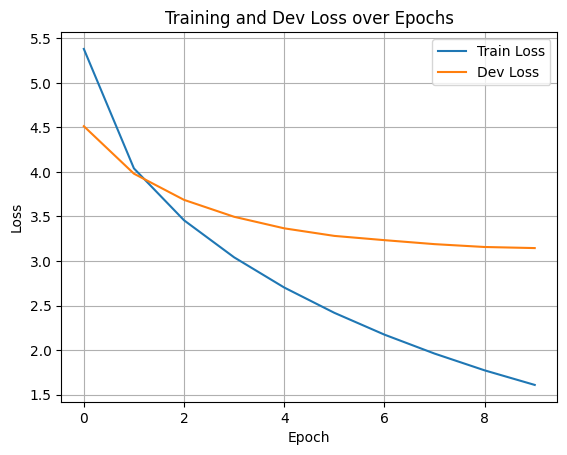

In [15]:
# Helper - loss visualizations
import matplotlib.pyplot as plt

def plot_losses(train_losses, dev_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Dev Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, dev_losses)

### Pedagogical Note: Interpreting the Loss Plots 🔍

After training completes, you'll see two curves:

- **Train Loss**: How well the model fits the training data.
- **Dev Loss**: How well the model generalizes to unseen (validation) data.

Ideally:
- Both curves should **decrease over time**.
- A small gap between them indicates **good generalization**.
- If train loss decreases but dev loss increases, your model may be **overfitting**.

Use these curves to decide if your model is learning stably and when to stop training.


## Step 4: Inference
Now that you have a trained model, you can use it to solve your task on any new data points.

Complete the code below for implementing a inference function for the model.

In [22]:
def infer_sentences(shuffled_sentences, model, word2idx, idx2word, device, max_len=50):
    """
    Generate predicted (unshuffled) sentences from a list of shuffled input sentences.

    Args:
        shuffled_sentences (List[str]): Sentences with words in randomized order.
        model (Seq2Seq): Trained encoder-decoder model.
        word2idx (Dict[str, int]): Mapping from words to vocabulary indices.
        idx2word (Dict[int, str]): Mapping from indices to words.
        device (torch.device): CPU or CUDA device for inference.
        max_len (int): Maximum sentence length to decode.

    Returns:
        List[str]: Model's predicted sentences (as plain strings).
    """
    model.eval()
    predictions = []

    sos_idx = word2idx['<SOS>']
    eos_idx = word2idx['<EOS>']
    pad_idx = word2idx['<PAD>']

    with torch.no_grad(): # Disable gradients for inference as they are not needed.
        for sentence in shuffled_sentences:
            # First, process the input sentence:
            # Tokenize, convert to IDs, pad, and convert to a tensor.
            input_token_ids = encode_sentence(sentence, word2idx, max_len)
            src_tensor = torch.tensor(input_token_ids, dtype=torch.long, device=device).unsqueeze(0) # Create a batch of 1.

            # The encoder expects (seq_len, batch_size), so transposing the tensor.
            src_tensor = src_tensor.T

            # Now, encode the input sentence.
            batch_size_for_inference = src_tensor.shape[1] # This will be 1 for single sentence inference.
            # Initialize the encoder's hidden state.
            encoder_hidden_init = model.encoder.init_hidden(batch_size_for_inference)
            
            # Pass the source tensor and initial hidden state to the encoder.
            # Only the final hidden state (the context vector) from the encoder is needed for simple seq2seq.
            _, encoder_final_hidden = model.encoder(src_tensor, encoder_hidden_init)

            # Initialize the decoder.
            # Use the encoder's final hidden state as the decoder's initial hidden state.
            decoder_hidden = encoder_final_hidden
            # Start decoding with the <SOS> token.
            decoder_input_token = torch.tensor([sos_idx] * batch_size_for_inference, dtype=torch.long, device=device)

            # Loop to generate the output sequence token by token.
            decoded_token_ids = []
            for _ in range(max_len): # Limit the decoding length to max_len to prevent infinite loops.
                # Feed the current input token and hidden state to the decoder.
                output_logits, decoder_hidden = model.decoder(decoder_input_token, decoder_hidden)
                # The decoder returns logits (scores) over the vocabulary.

                # Pick the token with the highest score (greedy decoding).
                top_next_token_id = output_logits.argmax(1)

                # If the model predicts the <EOS> token, decoding for this sentence is complete.
                if top_next_token_id.item() == eos_idx:
                    break

                # Otherwise, add the predicted token ID to the list.
                decoded_token_ids.append(top_next_token_id.item())
                # The predicted token becomes the input for the next decoding step.
                decoder_input_token = top_next_token_id

            # Finally, convert the list of predicted token IDs back to words.
            predicted_words = [idx2word[token_id] for token_id in decoded_token_ids]
            predicted_sentence: str = " ".join(predicted_words)
            predictions.append(predicted_sentence)

    return predictions


Now, use the above inference function to generate prediction for the **test set**. You are provided with the test set shuffled sentences in [this downloadable file](https://drive.google.com/file/d/178mEesTW89Ooz_f5bb6sHBHjAkG4DWMV/view?usp=sharing). In your submission, you should run the inference function of the provided list of shuffled sentences, to attain a `predicted_test.csv` file. Typically, these predictions over the test set will be evaluated against their annotated labels (targets).  

If you want to assess the quality of current trained model, you can run inference on the dev set and evaluate on it using the function below:

In [23]:
def evaluate_sentence_predictions(predictions, targets):
    """
    Compute exact match accuracy between predicted and target sentences (as strings).
    Args:
        predictions (List[str])
        targets (List[str])
    Returns:
        accuracy (float): percentage of exact string matches
    """
    correct = 0
    total = len(predictions)
    for pred, true in zip(predictions, targets):
        if pred.strip().lower() == true.strip().lower(): # Change it to ignore upper case
            correct += 1
    accuracy = correct / total * 100
    print(f"Exact match accuracy: {accuracy:.2f}%")
    return accuracy

In [24]:
# Evalute the model on dev dataset
predictions_for_input = infer_sentences(dev_df['input_sentence'], model, word2idx, idx2word, device)
print("Accuracy on dev:")
accuracy = evaluate_sentence_predictions(predictions_for_input, dev_df['target_sentence'])

Accuracy on dev:
Exact match accuracy: 3.37%


# Saving predictions file

In [25]:
# Define file paths
test_data_path = '/kaggle/input/test-no-target/test_no_target.csv'
output_csv_path = '/kaggle/working/seq2seq_predictions.csv'

# Load the test data
try:
    test_df = pd.read_csv(test_data_path)
    print(f"Test data loaded successfully from {test_data_path}")
    print(f"Test data shape: {test_df.shape}")
    print("Test data columns:", test_df.columns.tolist())
except FileNotFoundError:
    print(f"ERROR: Test data file not found at {test_data_path}")

    input_sentences_list = test_df['input_sentence'].tolist()

    # Generate predictions using infer_sentences function
    print(f"Generating predictions for {len(input_sentences_list)} sentences...")
    # Ensure the model is on the correct device if not already
    model.to(device)
    
    # Call the inference function
    predicted_sentences_list = infer_sentences(
        shuffled_sentences=input_sentences_list,
        model=model,
        word2idx=word2idx,
        idx2word=idx2word,
        device=device,
    )
    print("Predictions generated.")

    # Create a new DataFrame for the output
    output_df = pd.DataFrame({
        'input_sentence': input_sentences_list,  # The original sentences from the test set
        'prediction_sentence': predicted_sentences_list
    })

    # Save the DataFrame to a CSV file
    try:
        output_df.to_csv(output_csv_path, index=False)
        print(f"Predictions successfully saved to {output_csv_path}")
        
        # Display the first 5 predictions to see if the predictions make sense
        print("\nFirst 5 predictions:")
        print(output_df.head())
    except Exception as e:
        print(f"ERROR: Could not save predictions to {output_csv_path}. Error: {e}")

Test data loaded successfully from /kaggle/input/test-no-target/test_no_target.csv
Test data shape: (5000, 2)
Test data columns: ['Unnamed: 0', 'input_sentence']
Generating predictions for 5000 sentences...
Predictions generated.
Predictions successfully saved to /kaggle/working/seq2seq_predictions.csv

First 5 predictions:
                                      input_sentence  \
0  often play you when school? in high basketball...   
1                          what at I do. work I hard   
2                              prefer to sit down. I   
3  book gave the My is This yesterday. uncle a me...   
4  are There of books English lot a in library. this   

                                 prediction_sentence  
0  how many times you were when you use any other...  
1                i am looking forward at my brother.  
2                            i prefer to drink golf.  
3  my house is my best friend i bought my place f...  
4      there are a lot of books in any other things.  


# 🔁 Stage 2: Add Attention to Your Seq2Seq Model

In this stage, you'll implement a new model: **`Seq2SeqWithAttention`**.  
The goal is to improve your decoder by allowing it to "attend" to relevant parts of the encoder's outputs at each decoding step.

### 🧠 Why Attention?
The encoder compresses the entire input sentence into a single hidden state. This limits performance, especially on long sentences.

With attention, the decoder **dynamically focuses on different encoder outputs**, depending on what it's trying to generate.

---

### 🔧 What You Need to Implement:
You will create a new class `Seq2SeqWithAttention`, similar to `Seq2Seq`, but with the following differences:

1. At each decoding step, compute **attention scores** over all encoder hidden states.
2. Use those scores to compute a **context vector** (weighted sum of encoder outputs).
3. Feed the context vector into the decoder along with the embedding of the current input token.

---

### 📌 Tip: Dot-Product Attention
A simple form of attention you can implement is dot-product attention:

```python
score_t = dot(h_dec_t, h_enc_i) weights = softmax(score_t over i) context_t = sum_i weights[i] * h_enc_i
```

You'll apply this at every decoder time step.


In [26]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_size, decoder_hidden_size, encoder_hidden_size):
        super(DecoderRNNWithAttention, self).__init__()
        self.decoder_hidden_size = decoder_hidden_size
        self.encoder_hidden_size = encoder_hidden_size # This is the size of the context vector

        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # The input to the GRU will be the concatenation of the embedded token
        # and the context vector from the attention mechanism.
        self.gru_input_size = embedding_size + encoder_hidden_size
        self.gru = nn.GRU(self.gru_input_size, decoder_hidden_size, batch_first=False)

        # The output layer maps from the decoder's hidden state to vocabulary size.
        self.out = nn.Linear(decoder_hidden_size, vocab_size)

    def forward(self, input_token, hidden, context_vector):
        """
        input_token: (batch_size) - current token index at this decoding step
        hidden: (1, batch_size, decoder_hidden_size) - current decoder hidden state
        context_vector: (batch_size, encoder_hidden_size) - context vector from attention
        Returns:
            output: prediction for the next word (before softmax) (batch_size, vocab_size)
            hidden: updated decoder hidden state (1, batch_size, decoder_hidden_size)
        """
        # Add a sequence length dimension to the input_token (seq_len=1)
        # input_token shape: (batch_size) -> (1, batch_size)
        input_token_unsqueezed = input_token.unsqueeze(0)

        # Embed the input token
        # embedded shape: (1, batch_size, embedding_size)
        embedded = self.embedding(input_token_unsqueezed)

        # Unsqueeze context_vector to add sequence length dimension for concatenation
        # context_vector shape: (batch_size, encoder_hidden_size) -> (1, batch_size, encoder_hidden_size)
        context_vector_unsqueezed = context_vector.unsqueeze(0)

        # Concatenate the embedded input token and the context vector along the feature dimension
        # rnn_input shape: (1, batch_size, embedding_size + encoder_hidden_size)
        rnn_input = torch.cat((embedded, context_vector_unsqueezed), dim=2)

        # Pass concatenated input and hidden state to GRU
        # gru_output shape: (1, batch_size, decoder_hidden_size) (seq_len=1)
        # hidden shape: (1, batch_size, decoder_hidden_size)
        gru_output, hidden = self.gru(rnn_input, hidden)

        # Remove the sequence length dimension before passing to the linear layer
        # gru_output_squeezed shape: (batch_size, decoder_hidden_size)
        gru_output_squeezed = gru_output.squeeze(0)

        # Get predictions (logits) from the linear layer
        # output shape: (batch_size, vocab_size)
        output = self.out(gru_output_squeezed)

        return output, hidden

In [30]:
import torch.nn.functional as F

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder # This is an instance of DecoderRNNWithAttention and not the Seq2Seq decoder
        self.sos_idx = sos_idx
        self.device = device

        # For dot-product attention, if encoder_hidden_size == decoder_hidden_size,
        # no additional layers are strictly needed.

    def compute_attention(self, decoder_hidden, encoder_outputs):
        """
        Computes attention scores and context vector using dot-product attention.
        decoder_hidden: (1, batch_size, decoder_hidden_size) - current decoder GRU hidden state.
        encoder_outputs: (seq_len, batch_size, encoder_hidden_size) - all encoder GRU outputs.
                         Assumes decoder_hidden_size == encoder_hidden_size for dot product.

        Returns:
            context_vector: (batch_size, encoder_hidden_size)
        """
        # decoder_hidden is (num_layers=1, batch, dec_hid_size)
        # Permute decoder_hidden to be (batch, 1, dec_hid_size) for bmm
        query = decoder_hidden.permute(1, 0, 2)

        # encoder_outputs is (seq_len, batch, enc_hid_size)
        # Permute encoder_outputs to be (batch, seq_len, enc_hid_size) for bmm
        keys_values = encoder_outputs.permute(1, 0, 2)

        # Calculate attention scores (energy)
        # (batch, 1, dec_hid_size) @ (batch, enc_hid_size, seq_len) -> (batch, 1, seq_len)
        # This requires dec_hid_size == enc_hid_size
        energy = torch.bmm(query, keys_values.transpose(1, 2))

        # Apply softmax to get attention weights
        # dim=2 ensures softmax is over the source sequence length
        # attention_weights shape: (batch, 1, seq_len)
        attention_weights = F.softmax(energy, dim=2)

        # Compute context vector: weighted sum of encoder_outputs (values)
        # (batch, 1, seq_len) @ (batch, seq_len, enc_hid_size) -> (batch, 1, enc_hid_size)
        context_vector_unsq = torch.bmm(attention_weights, keys_values)

        # Squeeze context_vector to remove the middle dimension: (batch, enc_hid_size)
        context_vector = context_vector_unsq.squeeze(1)

        return context_vector

    def forward(self, src, trg):
        """
        src: (batch_size, seq_len) - input sentence
        trg: (batch_size, seq_len) - target sentence
        Returns:
            outputs: tensor of shape (batch_size, seq_len, vocab_size)
        """
        batch_size, trg_len = trg.shape
        # Access vocab_size from the decoder's output layer
        vocab_size = self.decoder.out.out_features

        # Create an empty tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        # Transpose inputs to match (seq_len, batch_size)
        src = src.T
        trg = trg.T

        # Initialize encoder hidden state on correct device
        encoder_initial_hidden = self.encoder.init_hidden(batch_size)

        # Encode the input sentence
        # encoder_outputs: (seq_len, batch_size, encoder_hidden_size)
        # decoder_hidden: (1, batch_size, decoder_hidden_size) -> from encoder's final state
        encoder_outputs, decoder_hidden = self.encoder(src, encoder_initial_hidden)

        # Start decoding with the <SOS> token
        input_token = torch.full((batch_size,), self.sos_idx, dtype=torch.long, device=self.device)

        for t in range(trg_len):
            # Compute context vector using attention
            # decoder_hidden is the current hidden state of the decoder's GRU
            # encoder_outputs are all hidden states from the encoder's GRU
            context_vector = self.compute_attention(decoder_hidden, encoder_outputs)

            # Decode one step
            # The decoder now takes input_token, its own hidden state, and the context_vector
            output, decoder_hidden = self.decoder(input_token, decoder_hidden, context_vector)

            outputs[:, t, :] = output
            input_token = trg[t]  # Teacher forcing: feed the true token at each step

        return outputs

## 📝 What You Need to Complete

- Implement the `compute_attention()` method to compute a context vector from encoder outputs given the current (decoder) hidden state.
- Update your `DecoderRNN` class so that it accepts and uses a context vector at every step:
    - One option is to **concatenate** the context vector with the embedded input token before passing it to the RNN.
    - Alternatively, you can feed the context into a projection layer together with the decoder hidden state.

---

### 📌 Tip: Updated Decoder Signature

You may need to rewrite your decoder to look like:

```python
def forward(self, input_token, hidden, context_vector):
    ...
```
---
> 💡 **Note on Attention Implementation**

You are given flexibility in how you choose to implement the attention mechanism.

You may:
- Implement the **basic dot-product attention** we discussed in class.
- Or, explore a more expressive variant by adding a **linear projection** to the decoder hidden state or the encoder outputs — borrowing an idea from self-attention in Transformers.

As long as your implementation uses the decoder hidden state to compute attention over the encoder outputs and forms a context vector, you're free to experiment and design the solution that makes most sense to you.


## 2.2 - Evaluate and Compare

In this stage, you should use your adapted `Seq2SeqWithAttention` model, train it and evaluate its performance (on the dev set).  

In [35]:
import copy # For deep copying model state
import torch.optim as optim

def train_model_with_early_stopping(model, train_loader, dev_loader, optimizer, criterion, device, num_epochs=15, patience=3):
    """
    Trains the model with early stopping based on development set loss.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training set.
        dev_loader (DataLoader): DataLoader for the development/validation set.
        optimizer (Optimizer): The optimizer.
        criterion (Loss function): The loss function.
        device (torch.device): The device to train on (e.g., 'cuda' or 'cpu').
        num_epochs (int): Maximum number of epochs to train for.
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        tuple: (train_losses, dev_losses)
               train_losses: List of average training loss per epoch.
               dev_losses: List of average development loss per epoch.
               The function modifies the 'model' in-place to its best state.
    """
    model.to(device)
    train_losses = []
    dev_losses = []

    best_dev_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None # To store the state_dict of the best model

    print(f"Starting training with early stopping (patience={patience})...")

    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        epoch_train_loss = 0

        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()
            output = model(src, trg) # Forward pass

            # output shape: (batch, seq_len, vocab_size)
            # trg shape: (batch, seq_len)
            # Reshape for CrossEntropyLoss
            output_flat = output.view(-1, output.shape[-1]) # (batch * seq_len, vocab_size)
            trg_flat = trg.view(-1)                         # (batch * seq_len)

            loss = criterion(output_flat, trg_flat)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_epoch_train_loss)

        # Evaluation on development set
        model.eval() # Set model to evaluation mode
        epoch_dev_loss = 0
        with torch.no_grad():
            for src, trg in dev_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)
                output_flat = output.view(-1, output.shape[-1])
                trg_flat = trg.view(-1)
                loss = criterion(output_flat, trg_flat)
                epoch_dev_loss += loss.item()

        avg_epoch_dev_loss = epoch_dev_loss / len(dev_loader)
        dev_losses.append(avg_epoch_dev_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_epoch_train_loss:.4f} | Dev Loss: {avg_epoch_dev_loss:.4f}")

        # Early stopping logic
        if avg_epoch_dev_loss < best_dev_loss:
            best_dev_loss = avg_epoch_dev_loss
            # Deep copy the model's state_dict to save the best version
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"  New best dev loss: {best_dev_loss:.4f}. Saving model state.")
        else:
            epochs_no_improve += 1
            print(f"  Dev loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            print(f"Loading best model state with dev loss: {best_dev_loss:.4f}")
            if best_model_state:
                model.load_state_dict(best_model_state) # Load the best model parameters
            break # Exit the training loop

    # After the loop, if training finished without early stopping,
    # ensure the model has the parameters of the best epoch if one was found.
    # If early stopping occurred, the model is already set to its best state.
    if best_model_state and epochs_no_improve < patience :
        print("Training finished. Loading best model state achieved during training.")
        model.load_state_dict(best_model_state)

    return train_losses, dev_losses

In [31]:
sos_idx = word2idx['<SOS>']
eos_idx = word2idx['<EOS>']
pad_idx = word2idx['<PAD>']
unk_idx = word2idx['<UNK>']


def infer_sentences_with_attention(input_sentences, model, word2idx, idx2word, device, max_len=50):
    """
    Generate predicted sentences using the Seq2SeqWithAttention model.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient calculations
        for sentence_str in input_sentences:
            # Preprocess the input sentence
            token_ids = encode_sentence(sentence_str, word2idx, max_len) # Use your existing encode_sentence
            src_tensor = torch.tensor(token_ids, dtype=torch.long, device=device).unsqueeze(0)  # (1, max_len)
            src_tensor = src_tensor.T  # (max_len, 1) for encoder

            # Encoding
            batch_size_for_inference = src_tensor.shape[1] # Should be 1
            encoder_initial_hidden = model.encoder.init_hidden(batch_size_for_inference)
            encoder_outputs, decoder_hidden = model.encoder(src_tensor, encoder_initial_hidden)
            # encoder_outputs: (max_len, 1, encoder_hidden_size)
            # decoder_hidden: (1, 1, decoder_hidden_size) from encoder's final state

            # Decoding loop
            decoder_input_token = torch.tensor([sos_idx] * batch_size_for_inference, dtype=torch.long, device=device)
            predicted_token_ids_for_sentence = []

            for _ in range(max_len):
                # Compute attention context vector
                # decoder_hidden here is the previous step's decoder hidden state
                context_vector = model.compute_attention(decoder_hidden, encoder_outputs)
                # context_vector shape: (1, encoder_hidden_size)

                # Pass to decoder
                output_logits, decoder_hidden = model.decoder(decoder_input_token, decoder_hidden, context_vector)
                # output_logits shape: (1, vocab_size)

                # Greedy decoding
                top_next_token_id = output_logits.argmax(1) # Shape: (1)

                predicted_id = top_next_token_id.item()
                if predicted_id == eos_idx:
                    break
                predicted_token_ids_for_sentence.append(predicted_id)
                decoder_input_token = top_next_token_id # Use predicted token as next input

            # Postprocessing
            predicted_words = [idx2word.get(token_id, unk_idx) for token_id in predicted_token_ids_for_sentence]
            predicted_sentence = " ".join(predicted_words)
            predictions.append(predicted_sentence)
    return predictions

In [36]:
# Model Hyperparameters
embedding_size = 128  # You can experiment with these
encoder_hidden_size = 256
decoder_hidden_size = 256 # For dot-product attention, this often matches encoder_hidden_size

# Instantiate Encoder and new Decoder (DecoderRNNWithAttention)
print("Initializing model components with attention...")
attn_encoder = EncoderRNN(vocab_size, embedding_size, encoder_hidden_size)
attn_decoder = DecoderRNNWithAttention(vocab_size, embedding_size, decoder_hidden_size, encoder_hidden_size)

# Instantiate Seq2SeqWithAttention model
# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attn_model = Seq2SeqWithAttention(attn_encoder, attn_decoder, sos_idx, device)
attn_model.to(device)
print("Seq2SeqWithAttention model created and moved to device:", device)

# Optimizer and Criterion
optimizer_attn = optim.Adam(attn_model.parameters(), lr=0.001)
criterion_attn = nn.CrossEntropyLoss(ignore_index=word2idx[PAD])

# Training parameters
num_epochs_attn = 20 # Max epochs, early stopping might finish sooner
early_stopping_patience = 3 # Number of epochs to wait for dev loss improvement

print(f"\nStarting training for Seq2SeqWithAttention model...")
train_losses_attn, dev_losses_attn = train_model_with_early_stopping(
    attn_model,
    train_loader,
    dev_loader,
    optimizer_attn,
    criterion_attn,
    device,
    num_epochs=num_epochs_attn,
    patience=early_stopping_patience
)
print("Training with early stopping finished.")

Initializing model components with attention...
Seq2SeqWithAttention model created and moved to device: cuda

Starting training for Seq2SeqWithAttention model...
Starting training with early stopping (patience=3)...
Epoch 1/20 | Train Loss: 4.9524 | Dev Loss: 3.8867
  New best dev loss: 3.8867. Saving model state.
Epoch 2/20 | Train Loss: 3.1934 | Dev Loss: 3.1688
  New best dev loss: 3.1688. Saving model state.
Epoch 3/20 | Train Loss: 2.3326 | Dev Loss: 2.8289
  New best dev loss: 2.8289. Saving model state.
Epoch 4/20 | Train Loss: 1.7006 | Dev Loss: 2.6650
  New best dev loss: 2.6650. Saving model state.
Epoch 5/20 | Train Loss: 1.2153 | Dev Loss: 2.5396
  New best dev loss: 2.5396. Saving model state.
Epoch 6/20 | Train Loss: 0.8474 | Dev Loss: 2.5141
  New best dev loss: 2.5141. Saving model state.
Epoch 7/20 | Train Loss: 0.5961 | Dev Loss: 2.4914
  New best dev loss: 2.4914. Saving model state.
Epoch 8/20 | Train Loss: 0.4259 | Dev Loss: 2.5068
  Dev loss did not improve for 1 

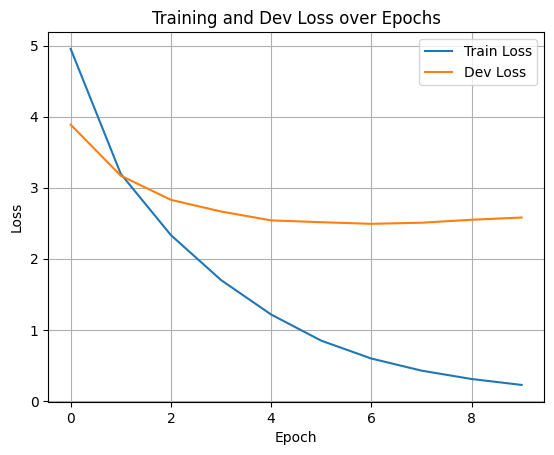

In [37]:
plot_losses(train_losses_attn, dev_losses_attn)

In [38]:
# --- Evaluate (if you have an evaluation function like evaluate_sentence_predictions) ---
print("\nEvaluating on development set with attention model...")
dev_input_sentences = dev_df['input_sentence'].tolist()
dev_target_sentences = dev_df['target_sentence'].tolist()

attn_predictions_dev = infer_sentences_with_attention(
    dev_input_sentences, attn_model, word2idx, idx2word, device, max_len=max_len # max_len from your setup
)

accuracy_attn = evaluate_sentence_predictions(attn_predictions_dev, dev_target_sentences)
print(f"Accuracy on dev set with Attention Model: {accuracy_attn:.2f}%")


Evaluating on development set with attention model...
Exact match accuracy: 14.54%
Accuracy on dev set with Attention Model: 14.54%


# Saving Seq2Seq with Attention model predictions

In [39]:
test_data_path_attn = '/kaggle/input/test-no-target/test_no_target.csv'
output_csv_path_attn = '/kaggle/working/seq2seq_with_attention_predictions.csv'

print(f"\nLoading test data from: {test_data_path_attn}")
try:
    test_df_attn = pd.read_csv(test_data_path_attn)
    if 'input_sentence' not in test_df_attn.columns:
        print(f"ERROR: 'input_sentence' column not found in {test_data_path_attn}. Available: {test_df_attn.columns}")
    else:
        test_input_sentences = test_df_attn['input_sentence'].tolist()
        print(f"Generating predictions for {len(test_input_sentences)} test sentences...")

        test_predictions_attn = infer_sentences_with_attention(
            test_input_sentences, attn_model, word2idx, idx2word, device, max_len=max_len # max_len from your setup
        )

        output_df_attn = pd.DataFrame({
            'input_sentence': test_input_sentences,
            'prediction_sentence': test_predictions_attn
        })

        output_df_attn.to_csv(output_csv_path_attn, index=False)
        print(f"Predictions saved to {output_csv_path_attn}")
        print("\nFirst 5 test predictions with attention:")
        print(output_df_attn.head())

except FileNotFoundError:
    print(f"ERROR: Test data file not found at {test_data_path_attn}")
except Exception as e:
    print(f"An error occurred during test prediction generation or saving: {e}")


Loading test data from: /kaggle/input/test-no-target/test_no_target.csv
Generating predictions for 5000 test sentences...
Predictions saved to /kaggle/working/seq2seq_with_attention_predictions.csv

First 5 test predictions with attention:
                                      input_sentence  \
0  often play you when school? in high basketball...   
1                          what at I do. work I hard   
2                              prefer to sit down. I   
3  book gave the My is This yesterday. uncle a me...   
4  are There of books English lot a in library. this   

                                 prediction_sentence  
0  how often did you play basketball when you wer...  
1                               i work at what i do.  
2                              i prefer to sit down.  
3  this is the book me a book near this book yest...  
4          there are a lot of books in this library.  


## 📌 Submission Instructions:
Submit your completed notebook along with two files of predictions over the test set - `seq2seq_predictions.csv` and `seq2seq_with_attention_predictions.csv`.

I will run the evaluation over the held-out test set.

You should email all of these files with an email specifying the names and ids of the team (couples).

✅ **Good luck!**
